In [ ]:
import os
import shutil
import zipfile
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import random


In [ ]:
zip_path = "/content/Bone.zip"
extract_to = "/content/bone"

os.makedirs(extract_to, exist_ok=True)

print("Extracting ZIP...")
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_to)

print("✔ Extraction complete!")


Extracting ZIP...
✔ Extraction complete!


In [ ]:
# Detect actual dataset folder
data_root = "/content/bone"

# Find folder that contains images (class folders)
for root, dirs, files in os.walk(data_root):
    if len(dirs) >= 2:
        dataset_dir = root
        print("Detected dataset folder:", dataset_dir)
        break


Detected dataset folder: /content/bone/Bone


In [ ]:
train_dir = os.path.join(dataset_dir, "train")
val_dir   = os.path.join(dataset_dir, "val")
test_dir  = os.path.join(dataset_dir, "test")

# The dataset is already split into train, val, test subfolders within dataset_dir.
# Therefore, we do not need to create new directories or re-split the images.
# The following lines related to folder creation and image splitting are removed.

# Determine the actual class names from one of the split directories, e.g., 'train'.
# This ensures we get actual class folders like 'fractured', 'not fractured', and filter out other files/folders.
classes = [d for d in os.listdir(train_dir)
           if os.path.isdir(os.path.join(train_dir, d)) and not d.startswith('.')] # Exclude hidden files like .ipynb_checkpoints

print("Found Classes:", classes)

# The dataset is already prepared with the correct train/val/test structure.
# No further splitting or copying of images is needed.

print("✔ Dataset prepared for direct use!")

Found Classes: ['fractured', 'not fractured']
✔ Dataset prepared for direct use!


In [ ]:
img_height, img_width = 224, 224
batch_size = 32

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_gen.flow_from_directory(
    train_dir, target_size=(img_height, img_width),
    batch_size=batch_size, class_mode="binary"
)

val_generator = val_gen.flow_from_directory(
    val_dir, target_size=(img_height, img_width),
    batch_size=batch_size, class_mode="binary"
)

test_generator = test_gen.flow_from_directory(
    test_dir, target_size=(img_height, img_width),
    batch_size=batch_size, class_mode="binary",
    shuffle=False
)


Found 4097 images belonging to 2 classes.
Found 404 images belonging to 2 classes.
Found 399 images belonging to 2 classes.


In [ ]:
base_model = EfficientNetB0(weights="imagenet", include_top=False,
                            input_shape=(img_height, img_width, 3))

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
checkpoint_cb = callbacks.ModelCheckpoint(
    "best_fracture_model.h5", monitor="val_accuracy",
    save_best_only=True, mode="max"
)

earlystop_cb = callbacks.EarlyStopping(
    monitor="val_accuracy", patience=6, restore_best_weights=True
)

reduce_lr_cb = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.3, patience=3, verbose=1
)


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.6312 - loss: 0.6306

129/129 ━━━━━━━━━━━━━━━━━━━━ 110s 635ms/step - accuracy: 0.6318 - loss: 0.6301 - val_accuracy: 0.8391 - val_loss: 0.3911 - learning_rate: 1.0000e-04
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.7875 - loss: 0.4530

129/129 ━━━━━━━━━━━━━━━━━━━━ 51s 392ms/step - accuracy: 0.7876 - loss: 0.4529 - val_accuracy: 0.8663 - val_loss: 0.3147 - learning_rate: 1.0000e-04
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8422 - loss: 0.3776

129/129 ━━━━━━━━━━━━━━━━━━━━ 52s 405ms/step - accuracy: 0.8422 - loss: 0.3775 - val_accuracy: 0.9134 - val_loss: 0.2562 - learning_rate: 1.0000e-04
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.8707 - loss: 0.3234

129/129 ━━━━━━━━━━━━━━━━━━━━ 52s 400ms/step - accuracy: 0.8707 - loss: 0.3234 - val_accuracy: 0.9332 - val_loss: 0.2145 - learning_rate: 1.0000e-04
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8906 - loss: 0.2939

129/129 ━━━━━━━━━━━━━━━━━━━━ 51s 396ms/step - accuracy: 0.8905 - loss: 0.2939 - val_accuracy: 0.9480 - val_loss: 0.1989 - learning_rate: 1.0000e-04
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8950 - loss: 0.2792

129/129 ━━━━━━━━━━━━━━━━━━━━ 52s 401ms/step - accuracy: 0.8951 - loss: 0.2791 - val_accuracy: 0.9678 - val_loss: 0.1618 - learning_rate: 1.0000e-04
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9022 - loss: 0.2542

129/129 ━━━━━━━━━━━━━━━━━━━━ 52s 402ms/step - accuracy: 0.9023 - loss: 0.2541 - val_accuracy: 0.9728 - val_loss: 0.1388 - learning_rate: 1.0000e-04
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9207 - loss: 0.2293

129/129 ━━━━━━━━━━━━━━━━━━━━ 53s 408ms/step - accuracy: 0.9207 - loss: 0.2292 - val_accuracy: 0.9827 - val_loss: 0.1210 - learning_rate: 1.0000e-04
Epoch 9/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 51s 393ms/step - accuracy: 0.9335 - loss: 0.2059 - val_accuracy: 0.9678 - val_loss: 0.1149 - learning_rate: 1.0000e-04
Epoch 10/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 51s 392ms/step - accuracy: 0.9279 - loss: 0.2021 - val_accuracy: 0.9827 - val_loss: 0.1063 - learning_rate: 1.0000e-04
Epoch 11/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9407 - loss: 0.1832

129/129 ━━━━━━━━━━━━━━━━━━━━ 51s 398ms/step - accuracy: 0.9407 - loss: 0.1831 - val_accuracy: 0.9851 - val_loss: 0.0928 - learning_rate: 1.0000e-04
Epoch 12/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9461 - loss: 0.1706

129/129 ━━━━━━━━━━━━━━━━━━━━ 52s 404ms/step - accuracy: 0.9461 - loss: 0.1706 - val_accuracy: 0.9876 - val_loss: 0.0804 - learning_rate: 1.0000e-04
Epoch 13/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9500 - loss: 0.1611

129/129 ━━━━━━━━━━━━━━━━━━━━ 51s 399ms/step - accuracy: 0.9500 - loss: 0.1611 - val_accuracy: 0.9926 - val_loss: 0.0713 - learning_rate: 1.0000e-04
Epoch 14/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 51s 399ms/step - accuracy: 0.9486 - loss: 0.1532 - val_accuracy: 0.9926 - val_loss: 0.0708 - learning_rate: 1.0000e-04
Epoch 15/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 51s 398ms/step - accuracy: 0.9483 - loss: 0.1490 - val_accuracy: 0.9876 - val_loss: 0.0703 - learning_rate: 1.0000e-04
Epoch 16/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 52s 403ms/step - accuracy: 0.9577 - loss: 0.1324 - val_accuracy: 0.9901 - val_loss: 0.0586 - learning_rate: 1.0000e-04
Epoch 17/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9648 - loss: 0.1139

129/129 ━━━━━━━━━━━━━━━━━━━━ 52s 402ms/step - accuracy: 0.9648 - loss: 0.1140 - val_accuracy: 0.9950 - val_loss: 0.0525 - learning_rate: 1.0000e-04
Epoch 18/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 51s 397ms/step - accuracy: 0.9675 - loss: 0.1194 - val_accuracy: 0.9950 - val_loss: 0.0491 - learning_rate: 1.0000e-04
Epoch 19/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9647 - loss: 0.1164

129/129 ━━━━━━━━━━━━━━━━━━━━ 52s 401ms/step - accuracy: 0.9647 - loss: 0.1165 - val_accuracy: 0.9975 - val_loss: 0.0471 - learning_rate: 1.0000e-04
Epoch 20/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 51s 397ms/step - accuracy: 0.9685 - loss: 0.1103 - val_accuracy: 0.9926 - val_loss: 0.0420 - learning_rate: 1.0000e-04


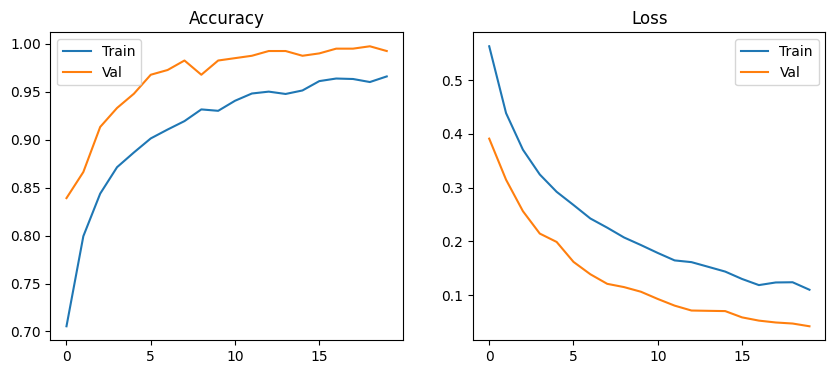

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(['Train', 'Val'])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(['Train', 'Val'])

plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n✔ Test Accuracy: {test_acc:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 914ms/step - accuracy: 0.9893 - loss: 0.0515

✔ Test Accuracy: 0.9825


In [ ]:
test_generator.reset()
preds = model.predict(test_generator)
y_pred = (preds > 0.5).astype(int)
y_true = test_generator.classes

print(classification_report(y_true, y_pred,
      target_names=list(test_generator.class_indices.keys())))

print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 634ms/step
               precision    recall  f1-score   support

    fractured       0.97      0.99      0.98       199
not fractured       0.99      0.97      0.98       200

     accuracy                           0.98       399
    macro avg       0.98      0.98      0.98       399
 weighted avg       0.98      0.98      0.98       399

Confusion Matrix:
 [[198   1]
 [  6 194]]


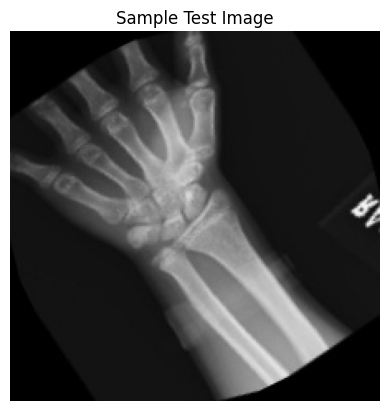

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Prediction: Fractured
Confidence: 76.74%


In [ ]:
test_class = random.choice(classes)
img_path = os.path.join(test_dir, test_class,
                        random.choice(os.listdir(os.path.join(test_dir, test_class))))

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
img_arr = tf.keras.preprocessing.image.img_to_array(img)
img_arr = preprocess_input(img_arr)

plt.imshow(img)
plt.title("Sample Test Image")
plt.axis("off")
plt.show()

pred = model.predict(np.expand_dims(img_arr, axis=0))[0][0]
label = "Fractured" if pred > 0.5 else "Normal"
confidence = pred if pred > 0.5 else 1 - pred

print(f"Prediction: {label}")
print(f"Confidence: {confidence*100:.2f}%")


📌 Upload an X-ray image to predict (JPG/PNG):


Saving 3-rotated1-rotated1-rotated3.jpg to 3-rotated1-rotated1-rotated3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


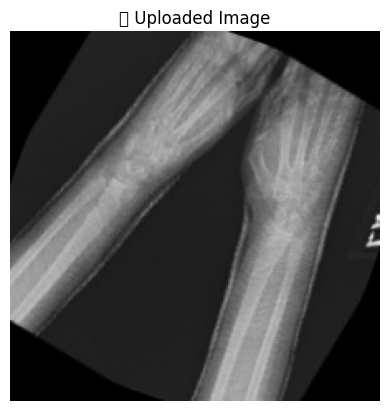


🧠 PREDICTION: 🦴 Fractured
📊 CONFIDENCE: 99.72%



In [ ]:
# ============================================================
# 🟦 USER INPUT IMAGE PREDICTION (FINAL & FIXED VERSION)
# ============================================================

from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

print("📌 Upload an X-ray image to predict (JPG/PNG):")
uploaded = files.upload()

for img_name in uploaded.keys():

    # Load & resize image
    img_path = img_name
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Preprocess using EfficientNet
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Model prediction (0 = fractured, 1 = normal)
    prediction = model.predict(img_array)[0][0]

    # 🔥 FIXED LABEL MAPPING
    if prediction > 0.5:
        label = "✅ Normal"
        confidence = prediction * 100
    else:
        label = "🦴 Fractured"
        confidence = (1 - prediction) * 100

    # Show image
    plt.imshow(tf.keras.preprocessing.image.load_img(img_path))
    plt.axis('off')
    plt.title("🔍 Uploaded Image")
    plt.show()

    # Final Output
    print("\n==============================")
    print(f"🧠 PREDICTION: {label}")
    print(f"📊 CONFIDENCE: {confidence:.2f}%")
    print("==============================\n")
